# Brain MRI Skull Stripping

In [1]:
DATA_DIR_T2F = "/Users/eyash.p24/Desktop/MUJ/PBL5/PBL 5/Dataset/Brats/ASNR-MICCAI-BraTS2023-GLI-Challenge-Data/TrainingData/input_data_256/t2f/train"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [6]:
img_path = "/Users/eyash.p24/Desktop/MUJ/PBL5/PBL 5/Dataset/Brats/ASNR-MICCAI-BraTS2023-GLI-Challenge-Data/TrainingData/input_data_256/t2f/train/Image/image_BraTS-GLI-00000-000-t2f.jpeg"

In [7]:
img = Image.open(img_path)
img.format, img.mode, img.size

('JPEG', 'L', (180, 180))

In [8]:
np_file = "/Users/eyash.p24/Desktop/MUJ/PBL5/PBL 5/Dataset/Brats/ASNR-MICCAI-BraTS2023-GLI-Challenge-Data/TrainingData/input_data_4channels/Image/image_BraTS-GLI-00000-000.npy"

In [9]:
img2 = np.load(np_file)
img2.shape

(4, 180, 180)

# Skull Stripping

In [1]:
import os
import glob
import nibabel as nib
import matplotlib.pyplot as plt

import SimpleITK as sitk

from sklearn.preprocessing import MinMaxScaler
import numpy as np

import scipy.ndimage as ndi

In [2]:
# IXI_DIR = "D:\MedGAN\Dataset\IXI"
IXI_DIR = "/Users/eyash.p24/Desktop/MUJ/PBL5/PBL 5/Dataset/IXI"

In [3]:
ixi_list = os.listdir(IXI_DIR)
ixi_list

['.DS_Store', 'IXI-T1.tar', 'IXI-T2.tar', 'IXI-T1', 'IXI-T2']

In [8]:
T1_DIR = os.path.join(IXI_DIR, ixi_list[-2])
T2_DIR = os.path.join(IXI_DIR, ixi_list[-1])

T1_DIR, T2_DIR

('/Users/eyash.p24/Desktop/MUJ/PBL5/PBL 5/Dataset/IXI/IXI-T1',
 '/Users/eyash.p24/Desktop/MUJ/PBL5/PBL 5/Dataset/IXI/IXI-T2')

In [ ]:
/Users/eyash.p24/Desktop/MUJ/PBL5/PBL 5/Dataset/IXI/IXI-T2/zipped/IXI013-HH-1212-T2.nii.gz

In [11]:
# Testing with T1 dir
# t1_zipped_list = sorted(glob.glob(f'{T1_DIR}\zipped\*T1.nii.gz'))
# t2_zipped_list = sorted(glob.glob(f"{T2_DIR}\zipped\*T2.nii.gz"))

t1_zipped_list = sorted(glob.glob(f'{T1_DIR}/zipped/*T1.nii.gz'))
t2_zipped_list = sorted(glob.glob(f'{T2_DIR}/zipped/*T2.nii.gz'))

len(t1_zipped_list), len(t2_zipped_list)


(581, 578)

In [12]:
t1_zipped_list[0]

'/Users/eyash.p24/Desktop/MUJ/PBL5/PBL 5/Dataset/IXI/IXI-T1/zipped/IXI002-Guys-0828-T1.nii.gz'

In [13]:
scaler = MinMaxScaler()

In [8]:
# brain image cropping params for training dataset (Brats dataset)
SLICE = 80
Y_START = 35
Y_END = 215
X_START = 35
X_END = 215

In [14]:
# brian image cropping params for gan input training dataset (IXI dataset)
SLICE_GAN = 155

In [18]:
import nibabel as nib
import numpy as np

def convertNiiGztoNii(nii_gz_file_path, nii_file_path):
    try:
        nii_img = nib.load(nii_gz_file_path)  # Load the NIfTI image
        nii_data = nii_img.get_fdata()  # Get the image data as a NumPy array
        
        new_nii = nib.Nifti1Image(nii_data, affine=nii_img.affine)  # Recreate a NIfTI image with the same affine transform
        nib.save(new_nii, nii_file_path)  # Save it as a .nii file
        
        print(f"File saved as {nii_file_path}")
        return 1  # Success
    except Exception as e:
        print(f"Error converting {nii_gz_file_path}: {str(e)}")
        return 0  # Indicate failure


In [16]:
nii_gz_file = t1_zipped_list[0]
file_tail = os.path.split(nii_gz_file)
file_tail[-1][:-3]

'IXI002-Guys-0828-T1.nii'

In [ ]:
import os

# converts .nii.gz into .nii files 

list_error = []

for img in range(len(t1_zipped_list)):
    nii_gz_file = t1_zipped_list[img]
    nii_file_tail = os.path.basename(nii_gz_file).replace('.nii.gz', '.nii')
    
    nii_file_dir = os.path.join(T1_DIR, "Unzipped")
    os.makedirs(nii_file_dir, exist_ok=True)
    
    nii_file = os.path.join(nii_file_dir, nii_file_tail)
    print(nii_file)
    
    res = convertNiiGztoNii(nii_gz_file, nii_file)
    if res != 1:
        list_error.append((nii_file, res))

print('done')

if list_error:
    print("Errors encountered:")
    for error in list_error:
        print(error)

In [20]:
import os
import nibabel as nib
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt

In [59]:
def load_mri(mri_path):
    """Loads the .nii.gz MRI file and returns the image and affine matrix."""
    mri_img = nib.load(mri_path)
    return mri_img.get_fdata(), mri_img.affine, mri_img.header

def brain_extraction(mri_data, threshold=0.2):
    """
    Performs skull stripping using an intensity-based thresholding method.
    - `threshold`: Adjust this based on MRI contrast; lower values keep more brain matter.
    """
    # Normalize the intensity values (0 to 1)
    mri_data = (mri_data - np.min(mri_data)) / (np.max(mri_data) - np.min(mri_data))
    
    # Apply threshold to remove skull and background
    binary_mask = mri_data > threshold

    # Remove small disconnected regions (noise) using morphological operations
    cleaned_mask = ndi.binary_opening(binary_mask, structure=np.ones((3,3,3)))

    # Fill holes inside the brain region
    filled_mask = ndi.binary_closing(cleaned_mask, structure=np.ones((5,5,5)))

    # Apply the mask to extract the brain
    brain_only = mri_data * filled_mask

    return brain_only, filled_mask

def save_brain_extracted_mri(brain_data, affine, header, output_path):
    """Saves the extracted brain as a new NIfTI file."""
    output_folder = os.path.split(output_path)[0]
    os.makedirs(output_folder, exist_ok=True)
    brain_img = nib.Nifti1Image(brain_data, affine, header)
    nib.save(brain_img, output_path)
    print(f"Brain extracted MRI saved to: {output_path}")

def plot_slices(original, brain, slice_idx=60):
    """Plots a slice from the original and extracted brain MRI."""
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(ndi.rotate(original[:,slice_idx,:], 180), cmap='bone')
    # plt.imshow(original[:, slice_idx, :], cmap="gray")
    plt.title("Original MRI")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    # plt.imshow(brain[:, slice_idx, :], cmap="gray")
    plt.imshow(ndi.rotate(brain[:,slice_idx,:], 180), cmap='bone')
    plt.title("Brain Extracted MRI")
    plt.axis("off")

    plt.show()


Brain extracted MRI saved to: /Users/eyash.p24/Desktop/MUJ/PBL5/PBL 5/Dataset/IXI/IXI-T1/mask/IXI015-HH-1258-T1.nii.gz


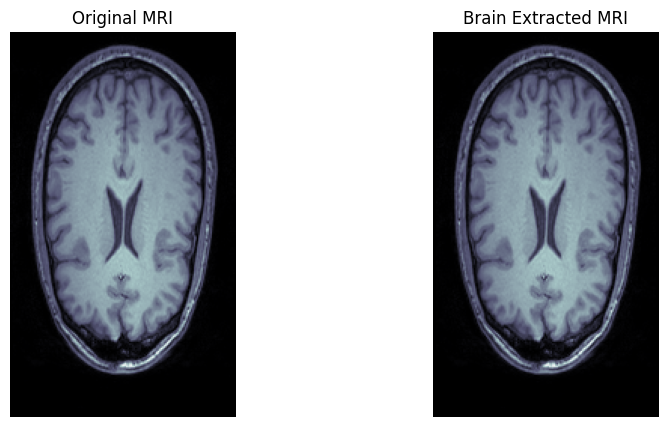

In [66]:
# Example Usage

input_mri_path = "/Users/eyash.p24/Desktop/MUJ/PBL5/PBL 5/Dataset/IXI/IXI-T1/zipped/IXI015-HH-1258-T1.nii.gz"  
output_mri_path = "/Users/eyash.p24/Desktop/MUJ/PBL5/PBL 5/Dataset/IXI/IXI-T1/mask/IXI015-HH-1258-T1.nii.gz"

# Load MRI
mri_data, affine, header = load_mri(input_mri_path)

# Perform skull stripping
brain_data, mask = brain_extraction(mri_data, threshold=0)

# Save the extracted brain MRI
save_brain_extracted_mri(brain_data, affine, header, output_mri_path)

# Plot a slice comparison
plot_slices(mri_data, brain_data, slice_idx=155)